In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

import warnings
warnings.filterwarnings("ignore")


In [10]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

print("Dataset shape:", X.shape)
print("Class distribution:\n", pd.Series(y).value_counts())

print("\nTotal missing values:", X.isnull().sum().sum())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Dataset shape: (569, 30)
Class distribution:
 1    357
0    212
Name: count, dtype: int64

Total missing values: 0


In [11]:
pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000))
])
pipe_dt = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestClassifier(random_state=42))
])


In [12]:
cv = StratifiedKFold(n_splits=5)

param_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring="roc_auc")
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)


param_dt = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_split": [2, 5, 10],
    "model__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(pipe_dt, param_dt, cv=cv, scoring="roc_auc")
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)


param_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(pipe_rf, param_rf, cv=cv, scoring="roc_auc")
grid_rf.fit(X_train, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)


Best Logistic Regression Params: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Best Decision Tree Params: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_split': 2}
Best Random Forest Params: {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}



===== Logistic Regression =====
Accuracy : 0.9736842105263158
Precision: 0.9726027397260274
Recall   : 0.9861111111111112
ROC-AUC  : 0.9957010582010581

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[40  2]
 [ 1 71]]


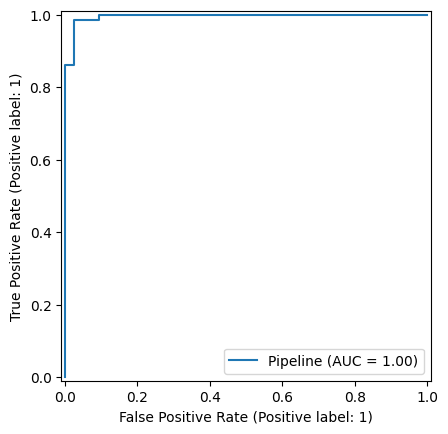


===== Decision Tree =====
Accuracy : 0.9473684210526315
Precision: 0.9459459459459459
Recall   : 0.9722222222222222
ROC-AUC  : 0.9447751322751323

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Confusion Matrix:
 [[38  4]
 [ 2 70]]


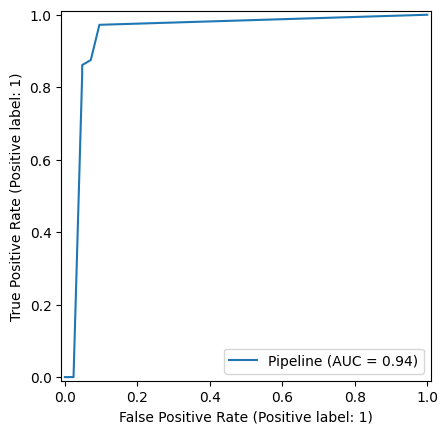


===== Random Forest =====
Accuracy : 0.956140350877193
Precision: 0.958904109589041
Recall   : 0.9722222222222222
ROC-AUC  : 0.9933862433862434

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix:
 [[39  3]
 [ 2 70]]


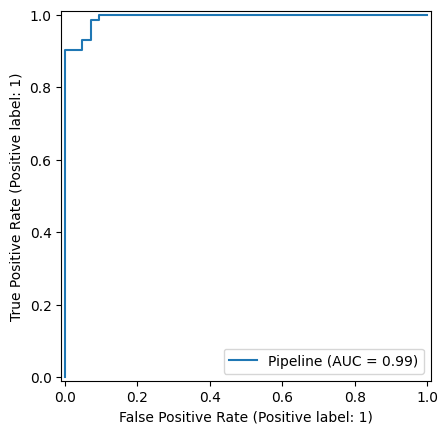

In [13]:
def evaluate(model, name):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    roc = roc_auc_score(y_test, prob)

    print(f"\n===== {name} =====")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("ROC-AUC  :", roc)

    print("\nClassification Report:\n", classification_report(y_test, pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()

    return acc, prec, rec, roc
lr_scores = evaluate(grid_lr.best_estimator_, "Logistic Regression")
dt_scores = evaluate(grid_dt.best_estimator_, "Decision Tree")
rf_scores = evaluate(grid_rf.best_estimator_, "Random Forest")


In [14]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "Accuracy": [lr_scores[0], dt_scores[0], rf_scores[0]],
    "Precision": [lr_scores[1], dt_scores[1], rf_scores[1]],
    "Recall": [lr_scores[2], dt_scores[2], rf_scores[2]],
    "ROC-AUC": [lr_scores[3], dt_scores[3], rf_scores[3]]
})

results.sort_values(by="ROC-AUC", ascending=False)


,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic Regression,0.973684,0.972603,0.986111,0.995701
2,Random Forest,0.956140,0.958904,0.972222,0.993386
1,Decision Tree,0.947368,0.945946,0.972222,0.944775
